In [1]:
'''
random_forest_all.py = here we build a random forest model to run over the K-fold CV
  Copyright (c) 2022 Charlie Payne
  Licence: GNU GPLv3
DESCRIPTION
  this notebook builds the optimal random forest model via the OptimalRF class
  it then runs the model for the dataset of your choice
  all the input data comes from running epg/run_PCA.py, which is the final script under epg/
NOTES
  [none]
RESOURCES
  -- https://www.datacamp.com/tutorial/random-forests-classifier-python
CONVENTIONS
  [none]
KNOWN BUGS
  [none]
DESIRED FEATURES
  [none]
'''

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
class OptimalRF():
    '''
    CLASS: OptimalRF = this finds the optimal random forest model via a random search method
    '''
    def __init__(self, X_train: np.ndarray, X_test: np.ndarray, y_train: pd.DataFrame, y_test: pd.DataFrame, nest: int, maxd: int) -> None:
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
        self.nest = nest
        self.maxd = maxd
    
    def find_best_rf(self):
        '''
        METHOD: find_best_rf = this method builds the RandomizedSearchCV() to find the optimal parameters for the random forest
        '''
        param_dist = {'n_estimators': randint(1, self.nest), 'max_depth': randint(1, self.maxd)}
        
        rf = RandomForestClassifier(class_weight="balanced")
        rand_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=5, cv=5)
        
        rand_search.fit(self.X_train, self.y_train['class'])
        
#         self.best_est = rand_search.best_estimator_
        self.best_params = rand_search.best_params_
        print('Best hyperparameters:', self.best_params)
    
    def train_best_rf(self):
        '''
        METHOD: train_best_rf = after find_best_rf, we now train the optimal random forest using the optimal parameters
        '''
        self.rf_best = RandomForestClassifier(max_depth=self.best_params['max_depth'], n_estimators=self.best_params['n_estimators'])
        self.rf_best.fit(self.X_train, self.y_train['class'])
    
    def make_prediction(self):
        '''
        METHOD: make_prediction = now make a prediction on the test data with the optimal random forest model
        '''
        self.y_pred = self.rf_best.predict(self.X_test)
    
    def calc_scores(self):
        '''
        METHOD: calc_scores = calculate the accuracy, precision, recall, and F1-score
        '''
        self.accuracy = accuracy_score(self.y_test['class'], self.y_pred)
        self.precision = precision_score(self.y_test['class'], self.y_pred)
        self.recall = recall_score(self.y_test['class'], self.y_pred)
        self.f1 = 2*self.precision*self.recall/(self.precision + self.recall)
        
        print("Accuracy =", self.accuracy)
        print("Precision =", self.precision)
        print("Recall =", self.recall)
        print("F1 =", self.f1, '\n')
    
    def print_confusion_matrix(self):
        '''
        METHOD: print_confusion_matrix = construct the confusion matrix on the test prediction
        '''
        cm = confusion_matrix(self.y_test['class'], self.y_pred)
        ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    
    def run(self):
        '''
        METHOD: run = run all the methods in order
        '''
        self.find_best_rf()
        self.train_best_rf()
        self.make_prediction()
        self.calc_scores()
        self.print_confusion_matrix()

In [ ]:
# use this and the next cell to run a single test_train_split or single fold

front_dir = '../../data/intermediates/pca/cond1_pat1to81_outrmv_kfold-5'
fold = 0
X_train = np.loadtxt(front_dir + '/X_train-' + str(fold) + '_cond1_pat1to81_outrmv_kfold-5.csv', delimiter=',')
X_test = np.loadtxt(front_dir + '/X_test-' + str(fold) + '_cond1_pat1to81_outrmv_kfold-5.csv', delimiter=',')
y_train = pd.read_csv(front_dir + '/y_train-' + str(fold) + '_cond1_pat1to81_outrmv_kfold-5.csv', index_col=0)
y_test = pd.read_csv(front_dir + '/y_test-' + str(fold) + '_cond1_pat1to81_outrmv_kfold-5.csv', index_col=0)

print('---- X_train ----')
print(X_train, '\n')
print('---- X_test ----')
print(X_test, '\n')
print('---- y_train ----')
display(y_train)
print('---- y_test ----')
display(y_test)

In [ ]:
%%time
orf = OptimalRF(X_train, X_test, y_train, y_test, 100, 10)
orf.run()

In [3]:
def control_metrics(y_test: pd.DataFrame) -> [float, float, float, float]:
    '''
    FUNCTION: control_metrics = calculate the metrics assuming we predict only 1's, this acts as a control
          IN: y_test = the dataframe from the input data
    '''
    num_HC = len([val for val in y_test['class'] if val == 0])
    num_SZ = len([val for val in y_test['class'] if val == 1])

    # assume predict only 1's, these values should be beaten by the random forest model's average metrics
    control_accuracy = (num_SZ + 0)/(num_SZ + num_HC + 0 + 0)  # (TP + TN)/(TP + FP + TN + FN)
    control_precision = num_SZ/(num_SZ + num_HC)  # TP/(TP + FP)
    control_recall = num_SZ/(num_SZ + 0)  # TP/(TP + FN)
    control_f1 = 2*control_precision*control_recall/(control_precision + control_recall)

    print("Control Accuracy =", control_accuracy)
    print("Control Precision =", control_precision)
    print("Control Recall =", control_recall)
    print("Control F1 =", control_f1)
    
    return control_accuracy, control_precision, control_recall, control_f1

Control Accuracy = 0.5625
Control Precision = 0.5625
Control Recall = 1.0
Control F1 = 0.72
Best hyperparameters: {'max_depth': 17, 'n_estimators': 31}
Accuracy = 0.5
Precision = 0.5333333333333333
Recall = 0.8888888888888888
F1 = 0.6666666666666667 

Control Accuracy = 0.625
Control Precision = 0.625
Control Recall = 1.0
Control F1 = 0.7692307692307693
Best hyperparameters: {'max_depth': 8, 'n_estimators': 139}
Accuracy = 0.625
Precision = 0.625
Recall = 1.0
F1 = 0.7692307692307693 

Control Accuracy = 0.625
Control Precision = 0.625
Control Recall = 1.0
Control F1 = 0.7692307692307693
Best hyperparameters: {'max_depth': 4, 'n_estimators': 108}
Accuracy = 0.625
Precision = 0.625
Recall = 1.0
F1 = 0.7692307692307693 

Control Accuracy = 0.6
Control Precision = 0.6
Control Recall = 1.0
Control F1 = 0.7499999999999999
Best hyperparameters: {'max_depth': 16, 'n_estimators': 56}
Accuracy = 0.6
Precision = 0.6
Recall = 1.0
F1 = 0.7499999999999999 

Control Accuracy = 0.6
Control Precision =

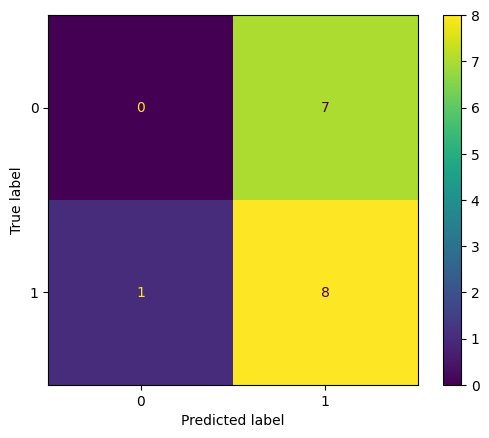

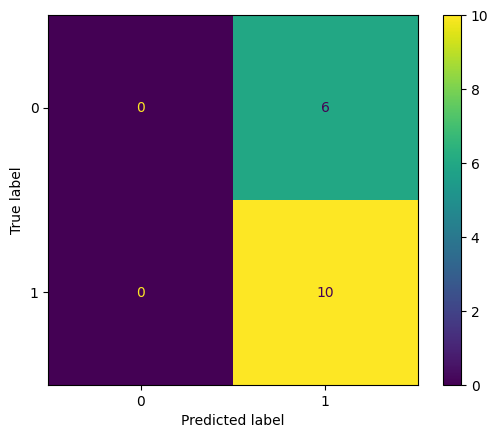

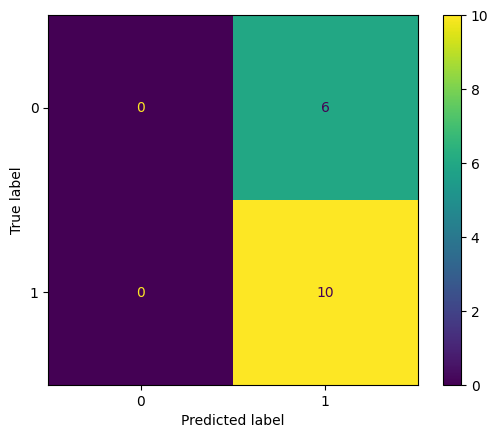

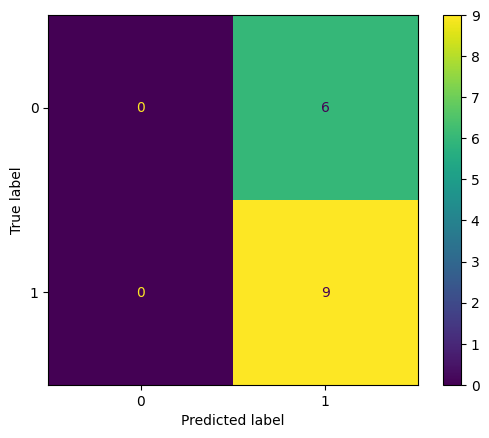

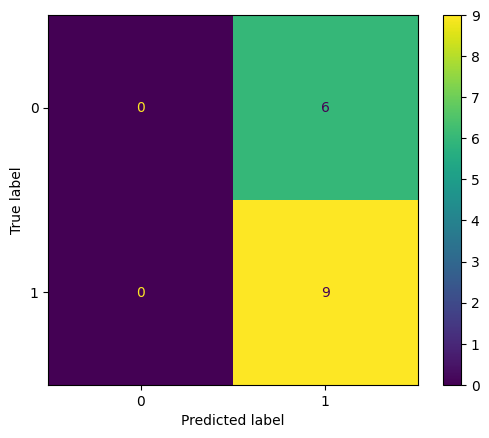

In [11]:
%%time

# this cell run over all the folds and optimizes each random forest and then calculates the average metrics

tot_folds = 5
# data_handle = 'cond1_pat1to81_outrmv_kfold-5'
# data_handle = 'cond2_pat1to81_outrmv_kfold-5'
data_handle = 'cond3_pat1to81_outrmv_kfold-5'
data_dir = '../../data/intermediates/pca/' + data_handle

n_est = 200  # maximum number of trees in the random forest to optimize over
max_d = 20   # maximum depth of said trees to optimize over

ctrl_accuracy = 0
ctrl_precision = 0
ctrl_recall = 0
ctrl_f1 = 0

avg_accuracy = 0
avg_precision = 0
avg_recall = 0
avg_f1 = 0

for ff in range(tot_folds):
    X_train = np.loadtxt(data_dir + '/X_train-' + str(ff) + '_' + data_handle + '.csv', delimiter=',')
    X_test = np.loadtxt(data_dir + '/X_test-' + str(ff) + '_' + data_handle + '.csv', delimiter=',')
    y_train = pd.read_csv(data_dir + '/y_train-' + str(ff) + '_' + data_handle + '.csv', index_col=0)
    y_test = pd.read_csv(data_dir + '/y_test-' + str(ff) + '_' + data_handle + '.csv', index_col=0)
    
    aprf1 = control_metrics(y_test)
    ctrl_accuracy += aprf1[0]
    ctrl_precision += aprf1[1]
    ctrl_recall += aprf1[2]
    ctrl_f1 += aprf1[3]
    
    orf = OptimalRF(X_train, X_test, y_train, y_test, n_est, max_d)
    orf.run()
    
    avg_accuracy += orf.accuracy
    avg_precision += orf.precision
    avg_recall += orf.recall
    avg_f1 += orf.f1

print('\n---------------------------------------------------------------------\n')
print(f"for: {data_handle}\n")
print(f"The average CONTROL accuracy, precision, recall, and F1-score:")
print("Accuracy =", ctrl_accuracy/tot_folds)
print("Precision =", ctrl_precision/tot_folds)
print("Recall =", ctrl_recall/tot_folds)
print("F1 =", ctrl_f1/tot_folds,'\n')
print(f"The average MODEL accuracy, precision, recall, and F1-score:")
print("Accuracy =", avg_accuracy/tot_folds)
print("Precision =", avg_precision/tot_folds)
print("Recall =", avg_recall/tot_folds)
print("F1 =", avg_f1/tot_folds)
print('\n---------------------------------------------------------------------\n')

In [ ]:
# F- I-- N---